## Eval local model checkpoint

In [3]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload

In [5]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as smp
from natsort import natsorted
from uloss_wmh.fitting.fitter import StandardLitModelWrapper
from uloss_wmh.fitting.optimizer_constructor import OptimizerConfigurator, standard_configurations
from tqdm import tqdm

In [6]:
from uloss_wmh.evaluate.eval_metrics.weighted_average_challenge_metrics import weighted_challenge_metrics

In [7]:
from uloss_wmh.evaluate.eval_metrics.challenge_metrics import do_challenge_metrics, per_model_chal_stats, challenge_results_combined_lists

In [8]:
# loss functions
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, DiceCELoss, DiceFocalLoss
from uloss_wmh.loss_functions.brier import Brier, BrierPlusDice
from uloss_wmh.loss_functions.odyssey_dice import SoftDiceLoss, DC_and_topk_loss
from uloss_wmh.loss_functions.odyssey_ND_Crossentropy import TopKLoss, CrossentropyND
from uloss_wmh.loss_functions.dice_plusplus import DicePlusPlusLoss

### loading the train, val and test datasets in 3D this time.

In [9]:
from ulw_data.torch_dataset.challenge_dataset_3D import load_3D_wmh_chal
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [10]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=3)

In [11]:
test_dss = load_3D_wmh_chal(ds_path=collated_folder, train=False, combine=False)

In [12]:
len(test_dss)

5

In [13]:
test_dss[4][0]['uid']

'test_Utrecht_1'

In [14]:
# computing the voxel histogram for each image in the test dataset.
example = test_dss[0][0]['image'][0]

In [15]:
flat = example.view(-1)
flat = flat[flat != 0]

In [16]:
# get volumes:
from uloss_wmh.evaluate.eval_metrics.WMH_volume import GT_volumes

ys3d = []
for ds in test_dss:
    for data in ds:
        label = data['label']
        ys3d.append(label)
    
volumes = GT_volumes(ys3d, 0.0003)

Text(0.5, 0, 'WMH Volume per individual - $mm^3$')

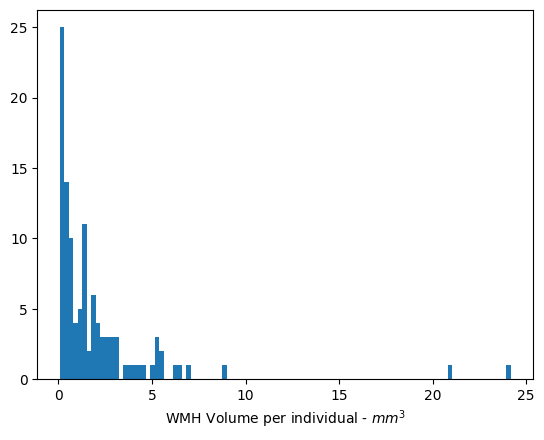

In [17]:
plt.hist(volumes, bins=100)
plt.xlabel(r"WMH Volume per individual - $mm^3$")

In [18]:
masks = []
for ds in test_dss:
    for data in ds:
        mask = data['image'][2]
        masks.append(mask)

In [19]:
labels_dss = [[] for _ in range(len(test_dss))]
labels = []

for i, ds in enumerate(test_dss):
    for data in ds:
        label = data['label'].squeeze()
        labels.append(label)
        labels_dss[i].append(label)

In [20]:
def plot_lesion_coverage_statistics1(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr):
    plt.plot(u_thresholds, mean_FN_coverage)
    plt.title(f"{loss_name} {lr}")
    plt.xlim((0, 0.7))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 1))
    plt.ylabel("mean FN coverage")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "mean_FN_coverage" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()
    
def plot_lesion_coverage_statistics2(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr):

    plt.plot(u_thresholds, size_entirely_missed_lesions)
    plt.title(f"{loss_name} {lr}")
    plt.xlim((0, 0.7))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 7))
    plt.ylabel("size of entirely missed lesions")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "size_entirely_missed_lesions" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()
    
def plot_lesion_coverage_statistics3(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr):
    plt.plot(u_thresholds, mean_missed_lesion_coverage)
    plt.title(f"{loss_name} {lr}")
    plt.xlim((0, 0.7))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 1))
    plt.ylabel("mean missed lesion coverage")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "mean_missed_lesion_coverage" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

    
def plot_lesion_coverage_statistics4(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr):
    
    plt.plot(u_thresholds, prop_entirely_missed)
    plt.title(f"{loss_name} {lr}")
    plt.xlim((0, 0.7))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 0.4))
    plt.ylabel("proprtion of lesions entirely missed in uncertainty map")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "prop_entirely_missed" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [22]:
def combined_challenge_metrics(preds_domain, labels_domain, model, loss_dir):
    results_domain = []
    for i in range(len(preds_domain)):
        results_domain.append(per_model_chal_stats([p>0.5 for p in preds_domain[i]], labels_domain[i], do_argmax=False))
        
    results_combined_df = challenge_results_combined_lists(results_domain, loss_dir)
    
    return results_combined_df, results_domain

In [23]:
def dice_distribution(combined_metrics, loss_name, lr):
    ### dice only.
    chart = sns.boxplot(data=combined_metrics, y="loss_name", x="dice")
    chart.set_yticklabels(chart.get_yticklabels(), rotation=90)
    title_str = f"Dice distribution - {loss_name} {lr}"
    plt.title(title_str)
    plt.xlim((0,1))
    plt.xlabel("Dice")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "dice_dist" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [24]:
def AVD_Dice_plot(data, loss_name, lr):
    sns.jointplot(data, x='dice', y='avd')
    plt.xlabel('Dice - per Test Set Individual')
    plt.ylabel('AVD - per Test Set Individual')
    plt.suptitle(f"AVD vs Dice: {loss_name}, {lr}")
    plt.xlim((0, 1))
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "avd_dice_plot" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [25]:
def AVD_Volume_plot(volumes, data, loss_name, lr):
    plt.scatter(volumes, data['avd'])
    plt.xscale('log')
    plt.title(f"AVD vs Volume: {loss_name}, {lr}")
    plt.xlabel("WMH GT volume")
    plt.ylabel("AVD")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "avd_volume_plot" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [26]:
def get_inputs(test_datasets):
    inputs = []
    for dataset in test_datasets:
        for data in dataset:
            inputs.append(data['image'])
    return inputs

def get_labels(test_datasets):
    labels = []
    for dataset in test_datasets:
        for data in dataset:
            labels.append(data['label'].squeeze())
    return labels


# since the area that I want to check is  predominantly confidently 0, I should compute values at n-step dilation.
from kornia.morphology import dilation

def dilate_considered_area(pred, label, threshold, steps=0):
    step0_area = (pred > threshold) | (label == 1)
    step0_area = step0_area.moveaxis(-1,0).unsqueeze(1) # step0_area requries shape B C H W
    
    result = step0_area.type(torch.float32)
    for step in range(steps):
        result = dilation(result, kernel=torch.ones(3, 3).to(result.device), engine='convolution')
    
    return result.squeeze().moveaxis(0, -1).type(torch.long)

def get_n_step_dilated_voxels(pred, label, threshold, steps):
    dilated = dilate_considered_area(pred, label, threshold=threshold, steps=steps)
    return pred[dilated==1]

def get_prediction_voxels(labels, model_preds, threshold=0.01, steps=2):
    prediction_voxels = []
    for i in tqdm(range(len(labels))):
        label = labels[i].cuda()
        pred = model_preds[i].cuda()
        voxels = get_n_step_dilated_voxels(pred, label, threshold=threshold, steps=steps)
        prediction_voxels.append(voxels.reshape(-1).cpu())

    prediction_voxels = torch.cat(prediction_voxels)
    return prediction_voxels

In [27]:
def softmax_confidence_distribution(prediction_voxels, loss_name, lr):
    sns.histplot(prediction_voxels, bins=20)
    plt.xlabel(f"Softmax Confidence - {loss_name}, {lr}")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "softmax_confidence_distribution" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [28]:


def compute_calibration_curve(predictions, labels, prediction_threshold=0., convert_to_numpy=True, num_bins=20):
    """Computes the calibration curve of a model.
    
    modified from a chat with google bard.

    Args:
    predictions: A list of pytorch tensors of shape (batch_size, height, width).
    labels: A list of pytorch tensors of shape (batch_size, height, width).
    prediction_threshold: the minimim prediction confidence to be considered

    Returns:
    A tuple of (calibration_curve, expected_calibration_error).
    The calibration_curve is a list of tuples of (confidence, accuracy).
    The expected_calibration_error is the average distance between the model's
    confidence and a perfectly calibrated model.
    
    """

    # Convert the predictions and labels to numpy arrays.
    if convert_to_numpy:
        predictions = torch.stack(predictions)
        labels = torch.stack(labels)
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

    # Bin the predictions into 10 equally spaced bins.
    bins = np.linspace(prediction_threshold, 1, num_bins)
    bin_indices = np.digitize(predictions, bins)
    #print(bins)
    
    # Compute the accuracy in each bin.
    accuracies = np.zeros(num_bins)
    confidences = np.zeros(num_bins)
    for i in tqdm(range(num_bins)):
        accuracies[i] = np.mean(labels[bin_indices == i])
        confidences[i] = np.mean(predictions[bin_indices == i])

    # Compute the expected calibration error.
    expected_calibration_error = np.mean(np.abs(confidences[1:] - accuracies[1:]))

    # Return the calibration curve and the expected calibration error.
    return (bins, confidences, accuracies), expected_calibration_error


In [29]:
# calibration per individual, and calibration score per volume
def compute_calibration_curve_per_individual(predictions, labels, prediction_threshold=0., convert_to_numpy=True, num_bins=20):
    """Computes the calibration curve of a model.
    
    modified from a chat with google bard.

    Args:
    predictions: A list of pytorch tensors of shape (batch_size, height, width).
    labels: A list of pytorch tensors of shape (batch_size, height, width).
    prediction_threshold: the minimim prediction confidence to be considered

    Returns:
    list of confidences, accuracies, eces for each individual.
    """

    # Convert the predictions and labels to numpy arrays.
    if convert_to_numpy:
        predictions = torch.stack(predictions)
        labels = torch.stack(labels)
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

    # Bin the predictions into 10 equally spaced bins.
    bins = np.linspace(prediction_threshold, 1, num_bins)
    bin_indices = np.digitize(predictions, bins)
    #print(bins)
    
    individual_accuracies = []
    individual_confidences = []
    individual_eces = []
    
    for j in tqdm(range(predictions.shape[0])):
        # Compute the accuracy in each bin.
        accuracies = np.zeros(num_bins)
        confidences = np.zeros(num_bins)
        for i in range(num_bins):
            accuracies[i] = np.mean(labels[j][bin_indices[j] == i])
            confidences[i] = np.mean(predictions[j][bin_indices[j] == i])

        # Compute the expected calibration error.
        expected_calibration_error = np.mean(np.abs(confidences[1:] - accuracies[1:]))
        
        individual_accuracies.append(accuracies)
        individual_confidences.append(confidences)
        individual_eces.append(expected_calibration_error)
        

    # Return the calibration curve and the expected calibration error.
    return individual_confidences, individual_accuracies, individual_eces


In [30]:
def plot_calibration(confidences, accuracies, ece, loss_name, lr):
    plt.plot([0,1],[0,1], c='black')
    plt.plot(confidences, accuracies)
    #plt.xlim((0.5, 1))
    #plt.ylim((0., 1))
    plt.xlabel("Softmax Confidence")
    plt.ylabel("Proportion of WMH")
    plt.title(f"Calibration Curve: {loss_name} {lr}\nECE: {ece:.3}")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "calibration" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [31]:
def individual_calib_plots(ind_confidences, ind_accuracies, ind_eces, loss_name, lr):
    plt.plot([0,1], [0,1], c='black')
    for i in range(60):
        plt.plot(ind_confidences[i], ind_accuracies[i])
    plt.title(f"Calibration Curves per individual - {loss_name} {lr}")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "calib_per_ind" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()
    
    plt.scatter(volumes, ind_eces)
    plt.xscale('log')
    plt.ylabel("Expected Calbiration Error (ECE) per individual")
    plt.xlabel(r"WMH Volume $mm^3$")
    plt.title(f"ECE vs Volume {loss_name} {lr}")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "calib_vs_volume" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [32]:
# precision and recall curve as the confidence threshold is varied
def precision_recall_curves(predictions, labels, num_bins=20):
    # TODO: I need to make this a weighted precision and recall at somepoint, and include does
    # with the metrics that I vary
    bins = np.linspace(0, 1, num_bins)
    
    precisions = []
    recalls = []
    
    for bin in tqdm(bins):
        tps = 0
        fps = 0
        fns = 0
        for i in range(len(predictions)):
            pred = predictions[i].cuda()
            label = labels[i].cuda()
            tps += ((pred > bin) * (label==1)).sum().item()
            fps += ((pred > bin) * (label==0)).sum().item()
            fns += ((pred < bin) * (label==1)).sum().item()
            
        precisions.append(tps / (tps + fps + 1e-8))
        recalls.append(tps / (tps + fns + 1e-8))
            
        
    return bins, precisions, recalls

def precision_recall_curve(bins, precisions, recalls, loss_name, lr):
    plt.plot(bins[1:-1], precisions[1:-1], label='precision')
    plt.plot(bins[1:-1], recalls[1:-1], label='recall')
    plt.xlabel("Softmax Threshold")
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.legend(loc='lower right')
    plt.title(f"Precision, Recall as Softmax \n Threshold Varies - {loss_name} {lr}")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "pres_recall_curve" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [33]:
def softmax_ent(preds):
    ent_maps = []
    for p in tqdm(preds):
        e = -(p * p.log() + (1-p) * (1-p).log())
        ent_maps.append(e)
        
    return ent_maps

In [34]:
from uloss_wmh.evaluate.eval_metrics.sUEO import sUEO

def UEO_curve(preds, ent_maps, labels, u_thresholds):
    t_ueo = []
    for tau in tqdm(u_thresholds):
        ueos = []
        for i in range(len(preds)):
            seg = preds[i].cuda() > 0.5
            error = seg != labels[i].cuda()
            ent = ent_maps[i].cuda() > tau
            
            numerator = 2 * (ent * error).sum()
            denominator = ent.sum() + error.sum()
            ueos.append((numerator/denominator).item())
        
        t_ueo.append(torch.Tensor(ueos).mean().item())
    
    return t_ueo

def plot_ueo_curve(u_thresholds, ueos, loss_name, lr):
    plt.plot(u_thresholds, ueos)
    plt.xlim((0,0.7))
    plt.ylim((0, 0.5))
    plt.xlabel("uncertainty threshold")
    plt.ylabel("UEO score")
    plt.title(f"UEO curve - {loss_name} {lr}")
    plt.savefig(f"initial_model_results/{loss_name}_{lr}/" + "ueo curve" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [35]:
%autoreload
from sklearn import metrics
from uloss_wmh.evaluate.eval_metrics.BraS import *
import math

def compute_BraS_Score(uncertainty_thresholds, preds, ent_maps, labels, masks):

    filtered_dices = []
    filtered_tns = []
    filtered_tps = []

    for i in tqdm(range(len(preds)), position=0, leave=True):
        pred = preds[i].cuda() > 0.5
        ent_map = ent_maps[i].cuda()
        y = labels[i].cuda()
        mask = masks[i].cuda()

        ind_filtered_dices = []
        ind_filtered_tns = []
        ind_filtered_tps = []

        if pred.sum() == 0:
            continue

        for t in uncertainty_thresholds:
            ind_filtered_dices.append(filtered_dice(pred, ent_map, y, t))
            ind_filtered_tns.append(filtered_tns_score(mask, pred, ent_map, y, t))
            ind_filtered_tps.append(filtered_tps_score(pred, ent_map, y, t))

        filtered_dices.append(ind_filtered_dices)
        filtered_tns.append(ind_filtered_tns)
        filtered_tps.append(ind_filtered_tps)


    # we need to calculate the area under the curve of the dice, so that will be mean dice per threshold?
    filtered_dices = torch.stack([torch.Tensor(v) for v in filtered_dices], dim=0)
    filtered_tns = torch.stack([torch.Tensor(v) for v in filtered_tns], dim=0)
    filtered_tps = torch.stack([torch.Tensor(v) for v in filtered_tps], dim=0)
    
    fdice_curve = filtered_dices.mean(dim=0)
    tn_curve = filtered_tns.mean(dim=0)
    tp_curve = filtered_tps.mean(dim=0)
    max_ent = math.log(0.5)
    bras_score = (1/3) * (
        metrics.auc(uncertainty_thresholds/max_ent, fdice_curve)
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tn_curve))
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tp_curve))
    )
    return bras_score

In [36]:
%autoreload
from uloss_wmh.evaluate.eval_metrics.connected_comps_analysis import conn_comp_2d_analysis

### compute the metrics for each metric

In [37]:
LOSS_FUNCTION_CONFIG = {
    "dice_topk":{"loss":DC_and_topk_loss({"do_bg":False}, {"k":10}), "outchannels":2},
    "dice_focal":{"loss":DiceFocalLoss(sigmoid=True, gamma=2.0), "outchannels":1},
    "dice_plusplus":{"loss":DicePlusPlusLoss(sigmoid=True, gamma=2), "outchannels":1},
    "cross_entropy":{"loss":CrossentropyND(), "outchannels":2},
    "brier":{"loss":Brier(sigmoid=True), "outchannels":1},
    "topk":{"loss":TopKLoss(k=10), "outchannels":2},
    "focal":{"loss":FocalLoss(gamma=2.0, reduction='sum'), "outchannels":1},
    "dice":{"loss":DiceLoss(sigmoid=True), "outchannels":1},
    "tversky_alpha.7":{"loss":TverskyLoss(sigmoid=True, alpha=0.7, beta=0.5), "outchannels":1},
    "tversly_beta.7":{"loss":TverskyLoss(sigmoid=True, alpha=0.5, beta=0.7), "outchannels":1},
    "soft_dice":{"loss":SoftDiceLoss(apply_nonlin=lambda x : torch.softmax(x, 1), do_bg=False, smooth=1e-5), "outchannels":2},
    "dice_brier":{"loss":BrierPlusDice(sigmoid=True, brier_factor=1/100, dice_factor=1), "outchannels":1},
    "generalized_dice":{"loss":GeneralizedDiceLoss(sigmoid=True), "outchannels":1},
    "dice_cross_entropy":{"loss":DiceCELoss(sigmoid=True), "outchannels":1},
    "":None,
}

size_average and reduce args will be deprecated, please use reduction='none' instead.


In [38]:
from uloss_wmh.models.hf_smp_unet_wrapper import SmpHfUnet

In [39]:
model1 = SmpHfUnet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# model2 = smp.Unet(
#         encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=2,                      # model output channels (number of classes in your dataset)
#     )

In [56]:
def load_model_preds(model, t=1):
    preds_dss = []
    with torch.no_grad():
        for ds in test_dss:
            preds_domain = []
            for data in tqdm(ds):
                inp = data['image'].cuda().moveaxis(-1, 0)
                out = model(inp)
                
                if out.shape[1] == 2:
                    out = torch.softmax(out/t, dim=1)[:,1]
                else:
                    out = torch.sigmoid(out/t)
                
                preds_domain.append(out.moveaxis(0, -1).squeeze().cpu())
            preds_dss.append(preds_domain)
    
    # get combined list of all domains together
    preds = []
    for p in preds_dss:
        preds.extend(p)
        
    return preds, preds_dss


def load_model_HF_preds(model, t=1):
    preds_dss = []
    with torch.no_grad():
        model.eval()
        for ds in test_dss:
            preds_domain = []
            for data in tqdm(ds):
                inp = data['image'].cuda().moveaxis(-1, 0)
                out = model(inp)[-1]
                
                if out.shape[1] == 2:
                    out = torch.softmax(out/t, dim=1)[:,1]
                else:
                    out = torch.sigmoid(out/t)
                
                preds_domain.append(out.moveaxis(0, -1).squeeze().cpu())
            preds_dss.append(preds_domain)
    
    # get combined list of all domains together
    preds = []
    for p in preds_dss:
        preds.extend(p)
        
    return preds, preds_dss

In [57]:
custom_optim_config = OptimizerConfigurator(optim='Adam', lr=2e-4, weight_decay=0, scheduler='ReduceOnPlateau', patience=12, threshold=1e-4, factor=0.3, min_lr=1e-6, monitor='train_loss', verbose_lr=True)

In [58]:
for i in range(1):
    
    ckpt_path = f"~/Documents/PhD_projects/LossFunctionsUQ/lossfuncs_WMH_UQ/uloss_wmh/run/testing/epoch=179-step=22694.ckpt"
    loss_name = "local test brier dice"
    lr = "2e-4"
    outchannels = 1
    loss_dir = "."
    
    print(loss_name)
    
    if lr == 'lr0.003':
        continue
    
    if outchannels == 2:
        model_base = model2
    else:
        model_base = model1
        
    model = StandardLitModelWrapper.load_from_checkpoint(checkpoint_path=ckpt_path, model=model_base, loss=None, optimizer_configurator=custom_optim_config)
    
    try:
        os.mkdir(f"initial_model_results/{loss_name}_{lr}")
    except:
        print("assume folder exists")
        
    preds, preds_dss = load_model_HF_preds(model)
    combined_metrics, metrics_per_domain = combined_challenge_metrics(preds_dss, labels_dss, model, loss_dir)
    
    chal_metrics = weighted_challenge_metrics(metrics_per_domain)
    print(chal_metrics)
    
#     dice_distribution(combined_metrics, loss_name, lr)
#     AVD_Dice_plot(combined_metrics, loss_name, lr)
#     AVD_Volume_plot(volumes,combined_metrics , loss_name, lr)
    
#     inputs = get_inputs(test_dss)
#     labels = get_labels(test_dss)
#     model_preds = preds
    
#     prediction_voxels = get_prediction_voxels(labels, model_preds, threshold=0.03, steps=0)  
#     softmax_confidence_distribution(prediction_voxels, loss_name, lr)    
#     (bins, confidences, accuracies), expected_calibration_error = compute_calibration_curve(model_preds, labels, prediction_threshold=0., num_bins=20)  
#     print("ECE: ", expected_calibration_error)
#     plot_calibration(confidences, accuracies, expected_calibration_error, loss_name, lr)
#     ind_confidences, ind_accuracies, ind_eces = compute_calibration_curve_per_individual(model_preds, labels, prediction_threshold=0., convert_to_numpy=True, num_bins=10)
#     individual_calib_plots(ind_confidences, ind_accuracies, ind_eces, loss_name, lr)
#     bins, precisions, recalls = precision_recall_curves(model_preds, labels)
#     precision_recall_curve(bins, precisions, recalls, loss_name, lr)
    
#     ent_maps = softmax_ent(model_preds)
#     u_thresholds = torch.arange(0, 0.75, 0.05)
#     ueos = UEO_curve(model_preds, ent_maps, labels, u_thresholds)
#     plot_ueo_curve(u_thresholds, ueos, loss_name, lr)
    
#     bras_score = compute_BraS_Score(u_thresholds, model_preds, ent_maps, labels, masks)
#     mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed = conn_comp_2d_analysis(u_thresholds, labels, model_preds, ent_maps)

#     plot_lesion_coverage_statistics1(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr)
#     plot_lesion_coverage_statistics2(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr)
#     plot_lesion_coverage_statistics3(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr)
#     plot_lesion_coverage_statistics4(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, loss_name, lr)

#     with open(f"initial_model_results/{loss_name}_{lr}/data.txt", "w") as f:
#         f.write(f"bras: {bras_score}\n")
#         f.write(f"ece: {expected_calibration_error}\n")
#         f.write(f"dice: {chal_metrics['dice']}\n")
#         f.write(f"f1: {chal_metrics['f1']}\n")
#         f.write(f"avd: {chal_metrics['avd']}\n")
#         f.write(f"hd95: {chal_metrics['hd95']}\n")
#         f.write(f"recall: {chal_metrics['recall']}\n")
#     # break

local test brier dice
assume folder exists


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.28it/s]

{'dice': 0.7300000190734863, 'f1': 0.7400000095367432, 'avd': 25.6299991607666, 'hd95': 4.0, 'recall': 0.7400000095367432}


performance without model.eval() on. There is a big difference here! (especially in AVD!!!)

{'dice': 0.7200000286102295, 'f1': 0.7300000190734863, 'avd': 33.040000915527344, 'hd95': 4.070000171661377, 'recall': 0.7699999809265137}




In [51]:
with torch.no_grad():
    for ds in test_dss:
        for data in tqdm(ds):
            inp = data['image'].cuda().moveaxis(-1, 0)
            out = model(inp)[-1]
            print(out[inp[:,2].unsqueeze(1)==1].sum())
        break

 20%|██████████████████████████████▊                                                                                                                           | 2/10 [00:00<00:01,  6.53it/s]

tensor(-9824468., device='cuda:0')
tensor(-8454376., device='cuda:0')


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 4/10 [00:00<00:00,  7.61it/s]

tensor(-9229462., device='cuda:0')
tensor(-12095422., device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6/10 [00:00<00:00,  7.89it/s]

tensor(-11357383., device='cuda:0')
tensor(-12954313., device='cuda:0')


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8/10 [00:01<00:00,  8.01it/s]

tensor(-11876437., device='cuda:0')
tensor(-9356236., device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]

tensor(-8602926., device='cuda:0')
tensor(-12245698., device='cuda:0')


In [53]:
with torch.no_grad():
    model.eval()
    for ds in test_dss:
        for data in tqdm(ds):
            inp = data['image'].cuda().moveaxis(-1, 0)
            out = model(inp)[-1]
            print(out[inp[:,2].unsqueeze(1)==1].sum())
        break

 20%|██████████████████████████████▊                                                                                                                           | 2/10 [00:00<00:01,  7.37it/s]

tensor(-10153560., device='cuda:0')
tensor(-7839388.5000, device='cuda:0')


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 4/10 [00:00<00:00,  8.14it/s]

tensor(-9195974., device='cuda:0')
tensor(-12374337., device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6/10 [00:00<00:00,  8.34it/s]

tensor(-11329378., device='cuda:0')
tensor(-12456984., device='cuda:0')


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8/10 [00:00<00:00,  8.43it/s]

tensor(-12108043., device='cuda:0')
tensor(-9538880., device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]

tensor(-8481882., device='cuda:0')
tensor(-11816230., device='cuda:0')


In [437]:
torch.arange(5, 11, 5)

tensor([ 5, 10])

In [438]:
def calculate_best_tau(model):
    best_ece = 1
    best_tau = 1
    for t in torch.arange(5, 11, 5):
        print(t)
        preds, preds_dss = load_model_preds(model, t)
        model_preds = preds
        (bins, confidences, accuracies), expected_calibration_error = compute_calibration_curve(model_preds, labels, prediction_threshold=0., num_bins=20)  
        print("ECE: ", expected_calibration_error)
        if expected_calibration_error < best_ece:
            best_ece = expected_calibration_error
            best_tau = t
            
    return best_tau

In [439]:
calculate_best_tau(model)

tensor(5)


100%|████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


ECE:  0.19655046589236894
tensor(10)


100%|████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]

ECE:  0.18209188298493356


tensor(10)

In [441]:
loss_name

'tversly_beta.7'

In [440]:
preds, preds_dss = load_model_preds(model, 10)

100%|████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.30it/s]


In [444]:
model_preds = preds

In [445]:
(bins, confidences, accuracies), expected_calibration_error = compute_calibration_curve(model_preds, labels, prediction_threshold=0., num_bins=20) 

  0%|                                                                     | 0/20 [00:00<?, ?it/s]Mean of empty slice.
invalid value encountered in scalar divide
invalid value encountered in divide
100%|████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'initial_model_results/tversly_beta.7_lr0.0003/calibration.jpg'

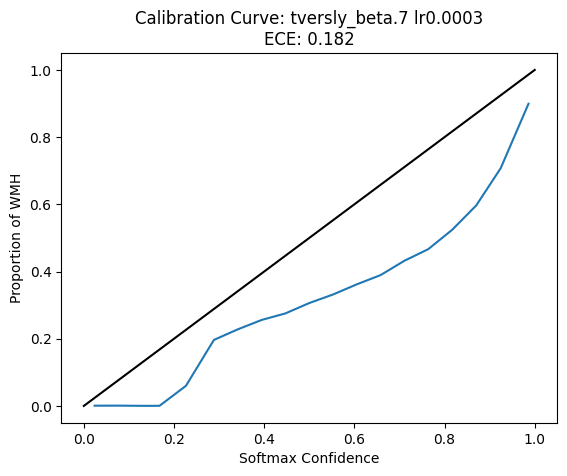

In [448]:
plot_calibration(confidences, accuracies, expected_calibration_error, loss_name, lr)

100%|████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.12it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'initial_model_results/tversly_beta.7_lr0.0003/ueo curve.jpg'

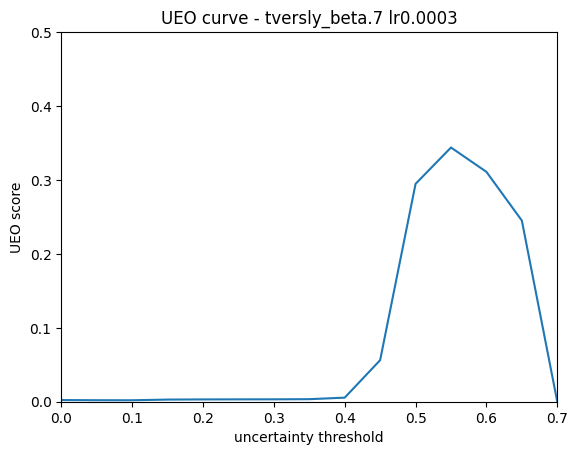

In [449]:
ent_maps = softmax_ent(model_preds)
ueos = UEO_curve(model_preds, ent_maps, labels, u_thresholds)
plot_ueo_curve(u_thresholds, ueos, loss_name, lr)


In [415]:
prediction_voxels.shape

torch.Size([245187768])

In [418]:
(prediction_voxels < 0.03).sum()

tensor(239299804)

### Another notebook for doing all of the above but with post-hoc calibration

### Storing results:

Saving all the plots and creating a text file with sUEO, BraS, Coverage at tau=0.4, mean challenge metrics, ece all recorded.

### other evaluation points to compute
for each of these it would be nice to be able to separate it per domain.
once I have these I have the full set of evaluations for any MICCAI paper that I want to write....
- [x] calculating volume
- [x] calibration (n step)
- [x] calibration vs volume n step
- [x] challenge metrics vs volume
- [ ] missing instances (and their size)
- [ ] introduced instances (and their size)
- [ ] uncertainty map coverage of missing lesions
- [ ] sUEO
- [ ] BraS score
- [ ] TP, FP FN scores
- [ ] post hoc calibration
- [ ] precision / recall per segmentation theshold as in the Dice++ paper.
- [ ] sample diversity / GeD (assuming I have an ensemble model, with an Ind output channel).
- [ ] lesion coverage in 2D and 3D axial slices
- [ ] pavpu metrics